# Predict volume area from LiDAR features

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

In [2]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular.preprocessing import *
from enveco.interpretation import *
from enveco.model.ensemble import *
from enveco.metrics import *

Run the example workflow for predicting the volume of the field plot from LiDAR-derived features.

# Read and preprocess data

In [3]:
#data_path = Path('../../../andras/ml/AV_leafon/')
data_path = Path('../../enveco_data/enveco/')

preprocessor = EnvecoPreprocessor(data_path/'AV.leaf.on.train.csv', 
                                  data_path/'AV.leaf.on.val.csv',
                                  data_path/'AV.leaf.on.test.csv')

Preprocess dataframes and extract lidar features from them. Specify which features are needed:

* height_features
* point_features
* intensity_features
* height_quantiles
* point_proportions
* canopy_densities

Also, specify whether to `normalize` data (default: True) or to log-transform target column (default: False)

In [4]:
preprocessor.train_df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v_ma,v_ku,v_lp,myear,filename_1,a_date_1,a_window_1,filename_2,a_date_2,a_window_2,v_lp_proc,is_valid
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,258.78,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121B3.laz,2013-07-11,C,NaN,NaN,NaN,77,0
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,3.50,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D1.laz,2013-07-11,C,NaN,NaN,NaN,2,0
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,18.79,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,8,0
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,76.84,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,24,0
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,0.00,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121F1.laz,2013-07-11,C,NaN,NaN,NaN,0,0


In [12]:
trainval_tb, test_tb = preprocessor.preprocess_lidar(target_col=['v'], path=data_path/'AV_las/', 
                                                     min_h=1.5,
                                                     height_features=True,
                                                     point_features=False, 
                                                     intensity_features=False, 
                                                     height_quantiles=False,
                                                     point_proportions=False, 
                                                     canopy_densities=False,
                                                     normalize=True,
                                                     log_y=False)

Adding height based features


Previous method returns two `TabularPandas` objects. Put them to dataloaders.

In [16]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock())

Check the distribution of the target variable `g`, in order to get limits for `sigmoid_range`.

In [7]:
trainval_tb.train.y.describe()

count    1044.000000
mean      145.712250
std        86.097336
min         2.700000
25%        80.927498
50%       132.125000
75%       191.305000
max       867.349976
Name: v, dtype: float64

In [8]:
trainval_tb.valid.y.describe()

count    225.000000
mean     150.768631
std       95.610825
min        2.310000
25%       87.419998
50%      133.600006
75%      191.639999
max      539.479980
Name: v, dtype: float64

In [9]:
test_tb.train.y.describe()

count    225.000000
mean     152.013641
std       97.223846
min        7.000000
25%       87.820000
50%      134.979996
75%      192.529999
max      550.169983
Name: v, dtype: float64

# ANN

Create `Learner` object. Specify y_range to better control the training, set 70 m² as the maximum value for basal area.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias. Target variable is log-transformed, so all metrics are log-equivalents (so MSLE, RMSLE...).

In [10]:
learn = tabular_learner(dls, metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  y_range=(0,1000))
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 58'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 58              116        True      
________________________________________________________________
BatchNorm1d          64 x 58              116        True      
________________________________________________________________
Linear               64 x 200             11,600     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________

Find learning rate to use.

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0020892962347716093)

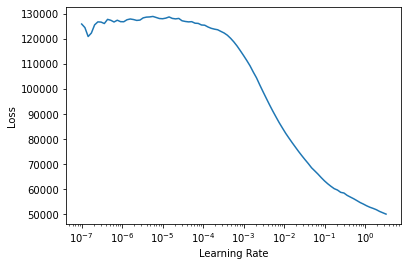

In [11]:
learn.lr_find()

1e-2 seems to be a good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,119647.843750,114389.531250,338.215210,224.327301,326.477356,216.541977,327.511780,-11.569171,00:00
1,99365.078125,62640.441406,250.280701,166.003174,231.107910,153.286469,235.158661,-5.882958,00:00
2,69663.398438,14598.212891,120.823067,80.138069,76.942032,51.033184,100.590279,-0.604058,00:00
3,45551.132812,3212.975098,56.683113,37.596092,14.278720,9.470617,40.702969,0.646957,00:00
4,30735.822266,2161.756836,46.494694,30.838438,-2.105019,-1.396191,33.288990,0.762465,00:00
5,21493.876953,1886.994629,43.439548,28.812059,6.546900,4.342349,31.002344,0.792656,00:00
6,15443.703125,1621.034302,40.262070,26.704540,6.707839,4.449094,28.309868,0.821880,00:00
7,11311.652344,1560.424805,39.502213,26.200550,7.379195,4.894383,27.508741,0.828540,00:00
8,8545.669922,1918.146973,43.796658,29.048920,11.420774,7.575033,29.622396,0.789233,00:00
9,6498.835449,1660.483887,40.749035,27.027529,12.519774,8.303965,28.447275,0.817545,00:00


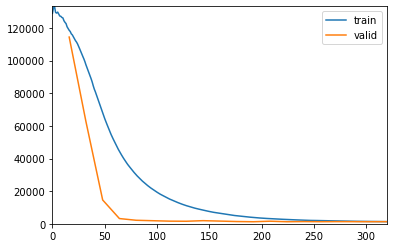

In [12]:
learn.fit_one_cycle(20, max_lr=1e-2, cbs=ShowGraphCallback())

In [13]:
preds, true = learn.get_preds()

In [14]:
preds.shape

torch.Size([225, 1])

See validation results

In [15]:
learn.validate()

(#7) [1316.206298828125,36.27955627441406,24.063066482543945,7.280226230621338,4.82874059677124,24.91204071044922,0.8553746928029082]

`RegressionInterpretation` can be used to plot results.

In [16]:
reg_interp = RegressionInterpretation.from_learner(learn, ds_idx=1)

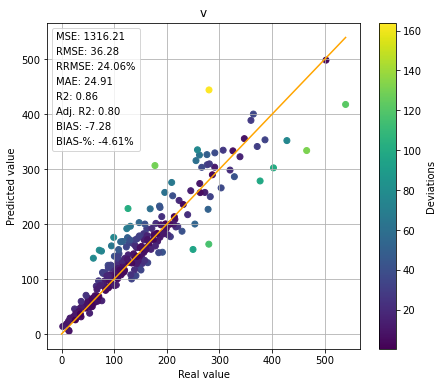

In [17]:
reg_interp.plot_results()
plt.show()

Evaluate test set.

In [18]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [19]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls.train, ds_idx=0)

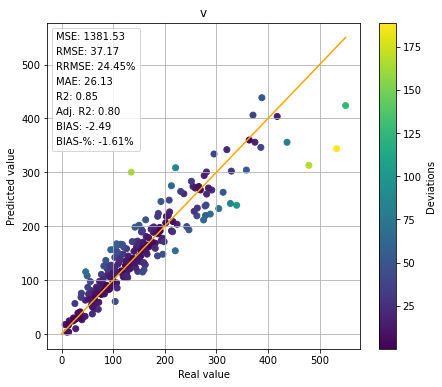

In [20]:
test_interp.plot_results()
plt.show()

# Ensemble of ANNs

Fit several models at once.

In [22]:
??tabular_learner

In [25]:
ensemble = Ensemble(dls, learn_func=tabular_learner,
                    y_range=(0,1000), 
                    metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], 
                    n_models=10)

In [26]:
ensemble.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,93138.570312,95206.835938,308.556030,204.655319,298.455688,197.956085,298.455688,-9.461368,00:00
1,75699.867188,47578.730469,218.125504,144.675659,201.273239,133.498093,204.769501,-4.227972,00:00
2,52251.917969,11217.155273,105.911072,70.247421,65.352386,43.346146,87.617859,-0.232546,00:00
3,34190.625000,3068.570557,55.394684,36.741520,13.060973,8.662925,40.286861,0.662824,00:00
4,23256.960938,2039.056274,45.155910,29.950466,-1.834041,-1.216460,32.903572,0.775948,00:00
5,16383.916992,1700.637939,41.238792,27.352369,2.137300,1.417602,30.387144,0.813133,00:00
6,11881.810547,1462.911621,38.248032,25.368694,2.587808,1.716410,28.283010,0.839255,00:00
7,8810.765625,1404.698730,37.479309,24.858826,1.801235,1.194701,27.191008,0.845651,00:00
8,6674.841309,1557.959106,39.470989,26.179842,11.555466,7.664371,27.998541,0.828811,00:00
9,5140.796875,1347.144165,36.703461,24.344229,7.537476,4.999366,25.900883,0.851975,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,122338.039062,114469.382812,338.333252,224.405594,328.682648,218.004669,328.869751,-11.577946,00:00
1,101350.273438,65267.656250,255.475372,169.448624,236.534195,156.885559,239.732849,-6.171638,00:00
2,72034.617188,20005.054688,141.439224,93.812103,89.913422,59.636688,116.378052,-1.198164,00:00
3,47501.953125,4544.560547,67.413353,44.713116,31.225496,20.710871,47.329929,0.500642,00:00
4,32007.710938,3101.606689,55.692074,36.938770,13.643018,9.048976,37.715443,0.659194,00:00
5,22366.531250,1960.663086,44.279377,29.369091,5.035955,3.340188,31.097343,0.784561,00:00
6,16037.602539,1755.536621,41.899124,27.790346,6.301194,4.179380,29.667484,0.807101,00:00
7,11789.772461,1833.471191,42.819057,28.400507,8.237534,5.463692,29.302670,0.798537,00:00
8,8769.125977,2022.812622,44.975689,29.830933,11.690405,7.753871,30.017677,0.777732,00:00
9,6647.038086,1663.008057,40.779991,27.048059,8.974200,5.952300,27.668627,0.817268,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,102313.484375,105535.750000,324.862640,215.470978,311.908569,206.878952,313.731903,-10.596314,00:00
1,85287.640625,56173.578125,237.009659,157.200912,221.997574,147.243881,225.704346,-5.172377,00:00
2,59559.476562,12124.335938,110.110565,73.032806,76.826942,50.956848,96.127922,-0.332227,00:00
3,38793.738281,2629.675781,51.280365,34.012623,18.652136,12.371364,36.953609,0.711050,00:00
4,26319.523438,1755.402954,41.897530,27.789289,-4.937449,-3.274852,30.084904,0.807116,00:00
5,18402.130859,1656.836304,40.704258,26.997829,-1.354539,-0.898422,29.223032,0.817946,00:00
6,13179.940430,1513.636719,38.905483,25.804762,1.857020,1.231702,28.167080,0.833681,00:00
7,9666.308594,1514.303833,38.914059,25.810448,4.298227,2.850876,28.265142,0.833608,00:00
8,7294.700195,1502.856445,38.766693,25.712704,3.893995,2.582762,27.897032,0.834865,00:00
9,5588.135254,1511.926025,38.883492,25.790173,4.273744,2.834638,27.693796,0.833869,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,106787.851562,108047.492188,328.705780,218.020004,315.059204,208.968674,315.920471,-10.872305,00:00
1,87042.695312,55439.851562,235.456680,156.170868,219.934113,145.875259,223.350830,-5.091755,00:00
2,60608.910156,14464.623047,120.268967,79.770554,76.875580,50.989109,100.820450,-0.589379,00:00
3,39836.375000,3722.608154,61.013180,40.468086,24.792061,16.443779,43.481026,0.590958,00:00
4,26878.472656,2120.388672,46.047680,30.541950,-0.247611,-0.164232,32.650776,0.767011,00:00
5,18844.966797,1866.678589,43.205074,28.656542,3.748366,2.486171,30.258192,0.794889,00:00
6,13628.660156,2313.245850,48.096214,31.900677,15.074225,9.998250,32.392441,0.745820,00:00
7,9988.647461,1690.529907,41.116058,27.270964,6.614495,4.387183,28.510279,0.814244,00:00
8,7511.287109,1653.510132,40.663376,26.970715,4.763249,3.159311,28.051304,0.818312,00:00
9,5723.079102,1706.251709,41.306801,27.397478,3.377885,2.240443,28.353804,0.812516,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,115546.835938,103958.218750,322.425537,213.854523,308.955536,204.920303,310.399048,-10.422975,00:00
1,95645.109375,60497.652344,245.962723,163.139191,229.349625,152.120255,232.908035,-5.647509,00:00
2,67656.757812,17841.617188,133.572510,88.594368,86.778831,57.557613,115.423508,-0.960445,00:00
3,44656.828125,3778.024414,61.465637,40.768188,27.749224,18.405170,46.206924,0.584869,00:00
4,30102.675781,2053.872559,45.319672,30.059084,1.315318,0.872408,32.291626,0.774320,00:00
5,21050.851562,1768.232544,42.050358,27.890656,4.421503,2.932641,30.092894,0.805706,00:00
6,15136.125000,1628.220947,40.351219,26.763672,1.684357,1.117180,29.426207,0.821090,00:00
7,11126.090820,1624.994995,40.311226,26.737144,0.699910,0.464228,28.726942,0.821445,00:00
8,8327.412109,1435.243896,37.884613,25.127649,2.788422,1.849471,26.338043,0.842295,00:00
9,6320.238770,1520.211426,38.989887,25.860743,3.679910,2.440766,27.463318,0.832959,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,146937.265625,130608.140625,361.397491,239.703369,351.558655,233.177597,351.706451,-13.351279,00:00
1,125834.882812,85056.703125,291.644806,193.438644,276.004852,183.065170,278.885773,-8.346066,00:00
2,91869.648438,26853.812500,163.871323,108.690598,118.326279,78.482025,139.901199,-1.950708,00:00
3,61368.339844,5823.326660,76.310730,50.614460,38.320744,25.416922,57.424099,0.360130,00:00
4,41248.167969,2658.447998,51.560139,34.198185,9.842481,6.528202,36.757618,0.707889,00:00
5,28636.453125,2020.703491,44.952236,29.815378,1.076638,0.714100,31.962635,0.777964,00:00
6,20414.429688,1866.161133,43.199089,28.652569,9.252588,6.136945,30.636436,0.794945,00:00
7,14819.627930,1729.753662,41.590309,27.585518,5.132607,3.404294,29.623993,0.809934,00:00
8,10952.764648,1581.139160,39.763542,26.373884,4.721495,3.131616,28.109613,0.826264,00:00
9,8208.391602,1496.781616,38.688267,25.660688,4.582043,3.039122,27.547373,0.835533,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,153814.453125,139830.265625,373.938843,248.021652,362.331970,240.323166,362.410767,-14.364610,00:00
1,130710.804688,84224.835938,290.215179,192.490417,275.544067,182.759537,276.714264,-8.254662,00:00
2,94487.015625,24540.039062,156.652603,103.902649,112.532402,74.639137,132.734665,-1.696470,00:00
3,62739.574219,5646.200195,75.141205,49.838753,33.895889,22.482056,55.949451,0.379593,00:00
4,42143.343750,2814.351318,53.050461,35.186668,2.581862,1.712466,36.780048,0.690758,00:00
5,29299.740234,2216.752441,47.082401,31.228247,6.039870,4.006052,31.818838,0.756422,00:00
6,20835.242188,2047.405029,45.248264,30.011723,9.094339,6.031984,30.348684,0.775030,00:00
7,15210.125000,1770.666504,42.079288,27.909842,-1.104671,-0.732693,28.719267,0.805438,00:00
8,11302.211914,1579.917358,39.748173,26.363689,3.411985,2.263060,26.321693,0.826398,00:00
9,8549.902344,1481.254028,38.487064,25.527235,5.553541,3.683486,26.023624,0.837239,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,122081.390625,116697.953125,341.610809,226.579498,323.837280,214.790894,326.218018,-11.822821,00:00
1,99687.007812,61607.449219,248.208466,164.628723,235.023483,155.883545,237.243774,-5.769452,00:00
2,69367.367188,14733.835938,121.383011,80.509460,85.120438,56.457661,104.319412,-0.618960,00:00
3,45277.484375,3186.377197,56.448002,37.440151,24.026300,15.935876,41.103294,0.649880,00:00
4,30407.482422,1899.221680,43.580059,28.905258,-1.043802,-0.692320,30.256336,0.791313,00:00
5,21269.830078,1935.863647,43.998451,29.182762,-6.322568,-4.193557,30.094225,0.787286,00:00
6,15276.313477,1480.592896,38.478470,25.521534,3.523986,2.337347,26.060781,0.837312,00:00
7,11216.861328,1663.412231,40.784950,27.051350,9.788254,6.492235,27.260351,0.817224,00:00
8,8399.095703,1497.099365,38.692371,25.663408,9.122975,6.050977,26.319254,0.835498,00:00
9,6377.727051,1347.822144,36.712696,24.350353,3.517571,2.333092,24.834641,0.851901,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,160061.343750,144685.906250,380.376007,252.291199,367.505219,243.754440,367.505188,-14.898149,00:00
1,135344.812500,89445.445312,299.074310,198.366409,283.493683,188.032272,285.122131,-8.828305,00:00
2,96960.625000,23364.337891,152.853973,101.383141,116.794807,77.466248,135.289841,-1.567284,00:00
3,63457.113281,4210.336426,64.887108,43.037540,32.281025,21.410969,47.439171,0.537366,00:00
4,42420.351562,2812.129883,53.029518,35.172779,12.356908,8.195941,37.421066,0.691002,00:00
5,29449.791016,1952.193604,44.183636,29.305590,2.784181,1.846658,31.739952,0.785492,00:00
6,20924.123047,1807.465698,42.514301,28.198374,8.079859,5.359111,30.532978,0.801395,00:00
7,15166.018555,1723.060181,41.509762,27.532095,10.385517,6.888381,29.602356,0.810669,00:00
8,11193.401367,1737.495117,41.683273,27.647179,7.660543,5.080993,29.802307,0.809083,00:00
9,8406.839844,1647.169434,40.585339,26.918953,0.789460,0.523624,28.938871,0.819008,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,101000.718750,103665.367188,321.971069,213.553101,309.192108,205.077209,309.841125,-10.390796,00:00
1,82574.914062,54945.058594,234.403625,155.472412,218.043640,144.621353,219.797745,-5.037387,00:00
2,57247.652344,13235.760742,115.046776,76.306839,69.968071,46.407578,92.718750,-0.454351,00:00
3,37543.480469,4199.431641,64.803017,42.981766,29.274324,19.416721,44.569820,0.538565,00:00
4,25530.617188,2181.492188,46.706451,30.978891,5.266351,3.493002,31.834692,0.760297,00:00
5,17975.523438,2304.009033,48.000092,31.836922,13.078874,8.674797,32.084751,0.746835,00:00
6,12962.774414,1762.484497,41.981956,27.845287,11.354328,7.530962,28.653776,0.806337,00:00
7,9553.615234,1701.672241,41.251331,27.360687,9.591049,6.361435,27.747276,0.813020,00:00
8,7174.727051,1519.510254,38.980896,25.854778,9.409159,6.240794,25.783005,0.833036,00:00
9,5495.221680,1427.219604,37.778557,25.057306,2.926213,1.940863,26.054855,0.843177,00:00


In [27]:
res = ensemble.validate()

See ensemble validation results.

In [28]:
res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,35.234062,23.369623,5.974349,3.962594,23.999998,0.863590
1,0,34.563744,22.925024,5.700592,3.781020,24.105322,0.868731
2,1,37.412373,24.814426,5.262789,3.490639,25.185682,0.846202
3,2,37.477077,24.857344,3.146867,2.087216,26.818802,0.845669
4,3,39.098732,25.932936,5.475015,3.631402,26.640480,0.832025
5,4,37.016369,24.551771,5.425365,3.598471,25.183283,0.849441
6,5,37.640667,24.965849,8.156693,5.410073,26.702574,0.844319
7,6,37.594147,24.934992,8.266539,5.482930,25.180286,0.844704
8,7,35.630539,23.632595,2.426695,1.609549,24.088177,0.860503
9,8,39.701336,26.332623,6.734073,4.466495,27.905853,0.826807


In [29]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

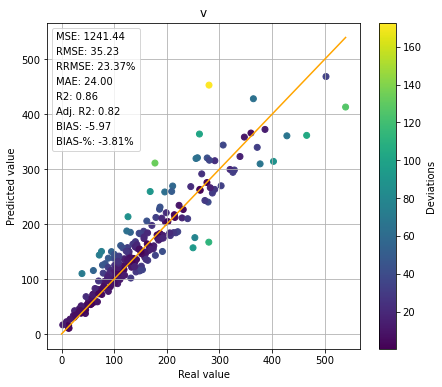

In [30]:
ens_int.plot_results()
plt.show()

Run test set predictions.

In [31]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,35.305450,23.225185,-0.013662,-0.008987,23.314631,0.867544
1,0,35.328590,23.240408,-0.962623,-0.633248,24.239416,0.867370
2,1,36.648453,24.108660,0.446567,0.293768,24.638548,0.857275
3,2,39.536808,26.008724,-2.813903,-1.851086,25.385996,0.833891
4,3,37.939663,24.958065,-0.744498,-0.489757,25.067835,0.847041
5,4,38.054108,25.033352,-0.851579,-0.560199,25.206373,0.846117
6,5,37.647060,24.765581,2.519304,1.657288,26.160662,0.849391
7,6,36.590157,24.070311,1.396147,0.918435,25.451168,0.857729
8,7,38.882347,25.578196,-2.941595,-1.935086,25.288179,0.839345
9,8,37.267052,24.515598,0.524841,0.345259,24.944632,0.852416


In [32]:
run_test_res = test_res[test_res.model_identifier != 'ensemble']

In [33]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

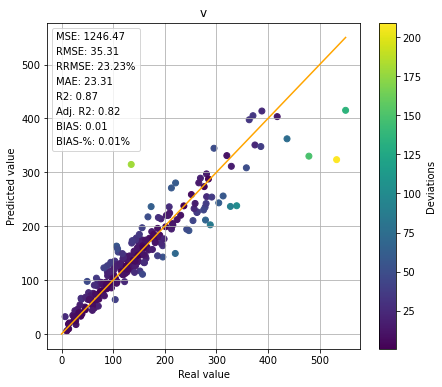

In [34]:
test_ens_interp.plot_results()
plt.show()

# Comparison: Random forest

`TabularPandas` makes it simple to use sklearn models with the same data and preprocessing.

In [35]:
from sklearn.ensemble import RandomForestRegressor

Below values for max_features and min_samples_leaf should generally work well.

In [36]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [37]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [38]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

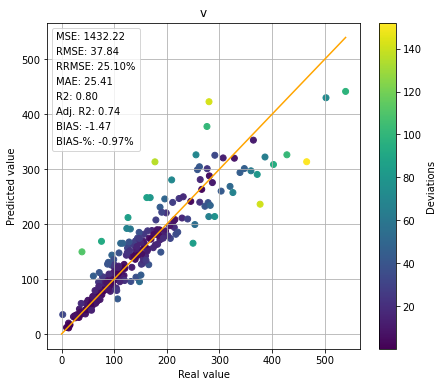

In [39]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys)
plt.show()

Test results

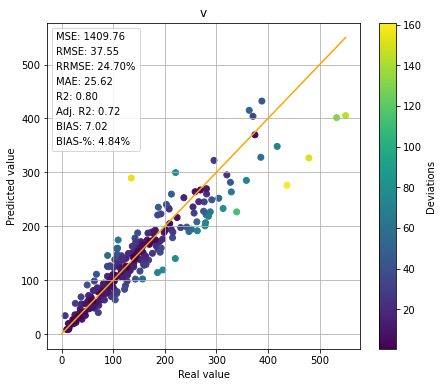

In [40]:
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()

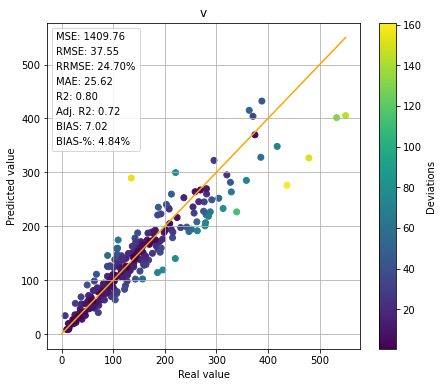

In [42]:
fig = plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show